In [1]:
import torch
import torch.nn as nn
import numpy as np
from utilis_ForsaV2 import *
import utilis_ForsaV2
# !pip install fxpmath\
from fxpmath import Fxp
import time
word_size  = 8
frac_size = 6
utilis_ForsaV2.word_size = word_size
utilis_ForsaV2.frac_size = frac_size
# from tensorboardX import SummaryWriter
# from transforms import *
# from models_cust import *
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.eval()

Using cache found in C:\Users\huruy/.cache\torch\hub\pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

3504872


In [3]:
# # Uncomment to visualize it in netron locally
# # Assuming `model` is your PyTorch model
# model_path = './PretrainedModels/MobileNetPretrainedIM1K.pth'

# # Save the entire model, including its architecture and trained parameters
# # torch.save(model, model_path)
# torch.jit.script(model).save(model_path)

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

3504872


# Demonstrating sorting for MobileNet_v2
a) Regular convolution followed by group convolution
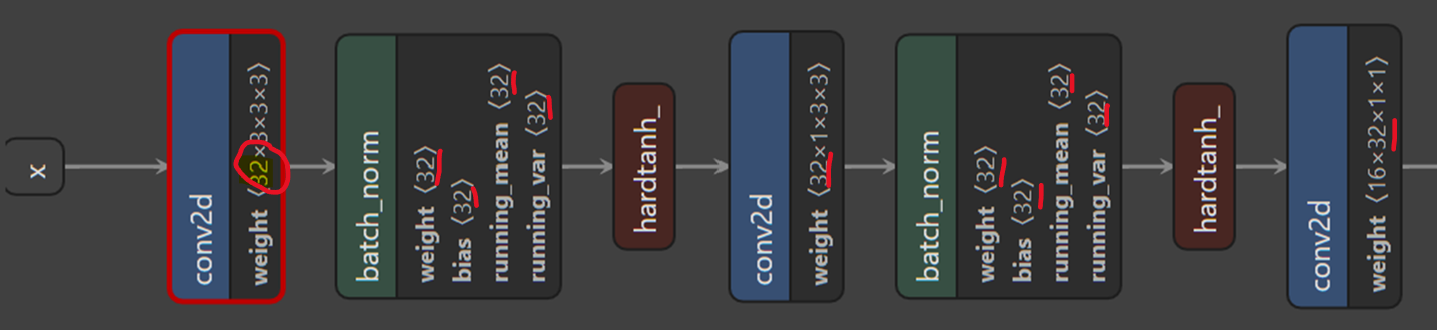

In [5]:
import torch

# Branch 1
# conv1_weight_reshaped, new_indx1 = sortFullMatrix(np.asarray(conv1_weight_reshaped.to('cpu').detach().numpy()))
###################### Sorting filter matrix, Generating indices, calculating switching before and after sorting
new_indx1 = torch.randperm(model.features[0][0].weight.shape[0])
# writer.add_histogram(f'convs',model.features[0][0].weight, 0)
# b1_conv_wt = model.features[0][0].weight.data
# m = nn.Flatten(1, -1)
# b1_conv_wt_mat = m(b1_conv_wt) 
# b1_conv_wt_bin = mat_2_bin(b1_conv_wt_mat.cpu().numpy())
# fixed_point_matrix = (b1_conv_wt_mat.cpu().numpy() * (2**frac_size)).astype(int)
# b1_conv_wt_mat = torch.flatten(model.features[0][0].weight.data.cpu(), -3).numpy()
################################
# fixed_point_matrix = (b1_conv_wt_mat * (2**frac_size)).astype(int)
# fixed_point_matrix_original = fixed_point_matrix.copy()
_, new_indx1 = sortFullMatrix_V2(model.features[0][0].weight) #########sortFullMatrix_V2##############
# sw_vector = calc_sw_act_V2(fixed_point_matrix_original)
# ################### after sorting
# sw_vector_sorted = calc_sw_act_V2(fixed_point_matrix_sorted)
# print('Switching before sorting', np.sum(sw_vector))
# print('Switching after sorting', np.sum(sw_vector_sorted))
# print('Percentage of reduction', (np.sum(sw_vector) - np.sum(sw_vector_sorted))*100/np.sum(sw_vector), '%')
################################
###################### End of Sorting filter matrix, Generating indices, calculating switching before and after sorting
model.features[0][0].weight.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[0][0].weight.data, new_indx1, -3, printsumm=True)
# plot_dist(model.features[0][0].weight)
# model.features[0][0].weight.data = model.features[0][0].weight[new_indx1, :, :, :]  

############
model.features[0][1].weight.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[0][1].weight, new_indx1, -1)
# plot_dist(model.features[0][1].weight)
# model.features[0][1].weight.data = model.features[0][1].weight[new_indx1] 
model.features[0][1].bias.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[0][1].bias, new_indx1, -1)
# plot_dist(model.features[0][1].bias)
# model.features[0][1].bias.data = model.features[0][1].bias[new_indx1]  
model.features[0][1].running_mean.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[0][1].running_mean, new_indx1, -1)
# plot_dist(model.features[0][1].running_mean)
# model.features[0][1].running_mean.data = model.features[0][1].running_mean[new_indx1]  
model.features[0][1].running_var.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[0][1].running_var, new_indx1, -1)
# plot_dist(model.features[0][1].running_var)
# model.features[0][1].running_var.data = model.features[0][1].running_var[new_indx1]  

Switching before sorting 3010.0
Switching after sorting 2324.0
Percentage of switching reduction 22.790697674418606 %


The above result shows approx 22.7% of reduction in switching (Switching associated with the convolution filters (32x3x3x3) sorted only) can be obtained by sorting the first layer. This needs to be followed by rearranging group convolution and the batchnormalization layers 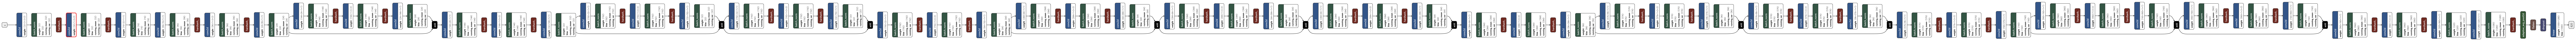

In [6]:
# Rearranging the group convolution that follows using new_indx1
model.features[1].conv[0][0].weight.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[1].conv[0][0].weight, new_indx1, -1)
# plot_dist(model.features[1].conv[0][0].weight)
# model.features[1].conv[0][0].weight.data = model.features[1].conv[0][0].weight[new_indx1, :, :, :]  
############
model.features[1].conv[0][1].weight.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[1].conv[0][1].weight, new_indx1, -1)
# plot_dist(model.features[1].conv[0][1].weight)
# model.features[1].conv[0][1].weight.data = model.features[1].conv[0][1].weight[new_indx1] 
model.features[1].conv[0][1].bias.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[1].conv[0][1].bias, new_indx1, -1)
# plot_dist(model.features[1].conv[0][1].bias)
# model.features[1].conv[0][1].bias.data = model.features[1].conv[0][1].bias[new_indx1]  
model.features[1].conv[0][1].running_mean.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[1].conv[0][1].running_mean, new_indx1, -1)
# plot_dist(model.features[1].conv[0][1].running_mean)
# model.features[1].conv[0][1].running_mean.data = model.features[1].conv[0][1].running_mean[new_indx1]  
model.features[1].conv[0][1].running_var.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[1].conv[0][1].running_var, new_indx1, -1)
# plot_dist(model.features[1].conv[0][1].running_var)
# model.features[1].conv[0][1].running_var.data = model.features[1].conv[0][1].running_var[new_indx1]  

# Rearranging the regular convolution that follows along its dimension using new_indx1 (Propagated indices thgough the group convolution)
model.features[1].conv[1].weight.data = model.features[1].conv[1].weight[:, new_indx1, :, :]  

# 
b) Residual block  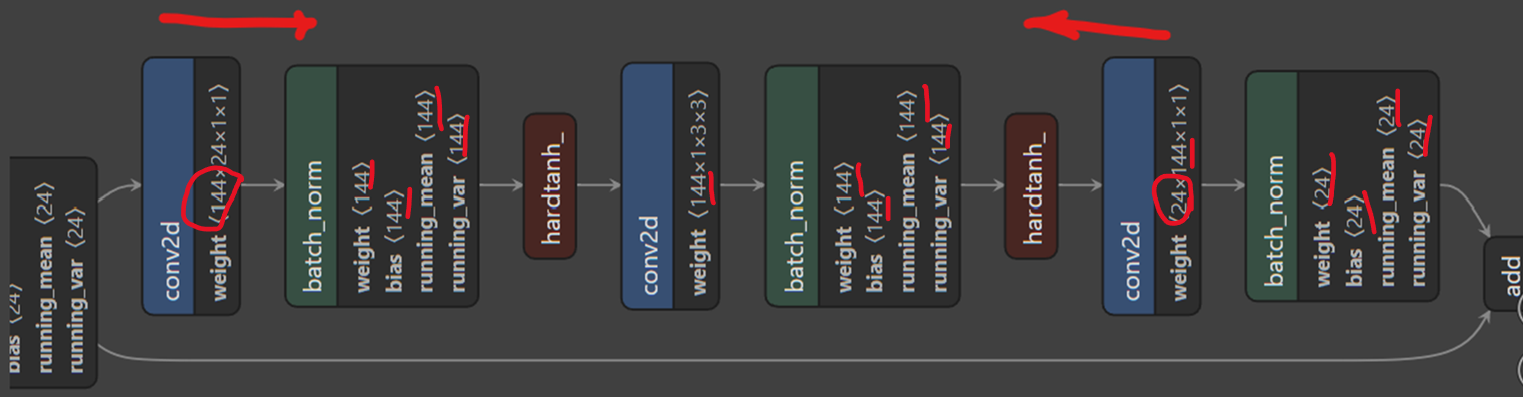

In [7]:
# Inverted residual block 1
# conv1_weight_reshaped, new_indx1 = sortFullMatrix(np.asarray(conv1_weight_reshaped.to('cpu').detach().numpy()))
# new_indxb1 = torch.randperm(model.features[3].conv[0][0].weight.shape[0]) # This needs to be commented when using the indices obtained from sorting
# b2_conv_wt = model.features[3].conv[0][0].weight.data
# m = nn.Flatten(1, -1)
# b2_conv_wt_mat = m(b2_conv_wt) 
# fixed_point_matrix = (b2_conv_wt_mat.cpu().numpy() * (2**frac_size)).astype(int)
# fixed_point_matrix_original = fixed_point_matrix.copy()
# fixed_point_matrix_sorted, new_indxb1 = sortFullMatrix_V2(fixed_point_matrix) #########sortFullMatrix_V2##############
fixed_point_matrix_sorted, new_indxb1 = sortFullMatrix_V2(model.features[3].conv[0][0].weight) #########sortFullMatrix_V2##############

# sw_vector = calc_sw_act_V2(fixed_point_matrix_original)
# ################### after sorting
# sw_vector_sorted = calc_sw_act_V2(fixed_point_matrix_sorted)
# print('Switching before sorting', np.sum(sw_vector))
# print('Switching after sorting', np.sum(sw_vector_sorted))
# print('Percentage of reduction', (np.sum(sw_vector) - np.sum(sw_vector_sorted))*100/np.sum(sw_vector), '%')
# ###################### End of Sorting filter matrix, Generating indices, calculating switching before and after sorting

model.features[3].conv[0][0].weight.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[3].conv[0][0].weight.data, new_indxb1, -3, printsumm=True)
# plot_dist(model.features[3].conv[0][0].weight)
# model.features[3].conv[0][0].weight.data = model.features[3].conv[0][0].weight[new_indxb1, :, :, :]  
############ rearranging batch norm features.3.conv.0.1
model.features[3].conv[0][1].weight.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[3].conv[0][1].weight, new_indxb1, -1)
# plot_dist(model.features[3].conv[0][1].weight)
# model.features[3].conv[0][1].weight.data = model.features[3].conv[0][1].weight[new_indxb1] 
model.features[3].conv[0][1].bias.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[3].conv[0][1].bias, new_indxb1, -1)
# plot_dist(model.features[3].conv[0][1].bias)
# model.features[3].conv[0][1].bias.data = model.features[3].conv[0][1].bias[new_indxb1]  
model.features[3].conv[0][1].running_mean.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[3].conv[0][1].running_mean, new_indxb1, -1)
# plot_dist(model.features[3].conv[0][1].running_mean)
# model.features[3].conv[0][1].running_mean.data = model.features[3].conv[0][1].running_mean[new_indxb1]  
model.features[3].conv[0][1].running_var.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[3].conv[0][1].running_var, new_indxb1, -1)
# plot_dist(model.features[3].conv[0][1].running_var)
# model.features[3].conv[0][1].running_var.data = model.features[3].conv[0][1].running_var[new_indxb1] 
############ rearranging group conv features.3.conv.1.0
model.features[3].conv[1][0].weight.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[3].conv[1][0].weight, new_indxb1, -3)
# plot_dist(model.features[3].conv[1][0].weight)
# model.features[3].conv[1][0].weight.data = model.features[3].conv[1][0].weight[new_indxb1, :, :,:] 
############ rearranging batch norm features.3.conv.1.1
model.features[3].conv[1][1].weight.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[3].conv[1][1].weight, new_indxb1, -1)
# plot_dist(model.features[3].conv[1][1].weight)
# model.features[3].conv[1][1].weight.data = model.features[3].conv[1][1].weight[new_indxb1] 
model.features[3].conv[1][1].bias.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[3].conv[1][1].bias, new_indxb1, -1)
# plot_dist(model.features[3].conv[1][1].bias)
# model.features[3].conv[1][1].bias.data = model.features[3].conv[1][1].bias[new_indxb1]  
model.features[3].conv[1][1].running_mean.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[3].conv[1][1].running_mean, new_indxb1, -1)
# plot_dist(model.features[3].conv[1][1].running_mean)
# model.features[3].conv[1][1].running_mean.data = model.features[3].conv[1][1].running_mean[new_indxb1]  
model.features[3].conv[1][1].running_var.data, sw_redc_rate ,_ ,_ = compare_sw_sort(model.features[3].conv[1][1].running_var, new_indxb1, -1)
# plot_dist(model.features[3].conv[1][1].running_var)
# model.features[3].conv[1][1].running_var.data = model.features[3].conv[1][1].running_var[new_indxb1]  

# Rearranging the group convolution that follows using new_indx1 (Propagated indices thgough the group convolution)
#  features.3.conv.2
# model.features[3].conv[2].weight.data, sw_redc_rate = compare_sw_sort(model.features[3].conv[2].weight, new_indxb1, -3)
# plot_dist(model.features[3].conv[2].weight)
model.features[3].conv[2].weight.data = model.features[3].conv[2].weight[:, new_indxb1, :, :] 

Switching before sorting 13596.0
Switching after sorting 9393.0
Percentage of switching reduction 30.9135039717564 %


D:\PhD_work\Thesis\FORSA\FORSAv2_git\PyTorch-Models\utilis_ForsaV2.py:109: RuntimeWarning: invalid value encountered in double_scalars
  sw_redc_rate = (np.sum(sw_vector) - np.sum(sw_vector_sorted))*100/np.sum(sw_vector)


The above result shows approx 30.9% of reduction in switching (Switching associated with the convolution filters (144x24x1x1) sorted only) can be obtained by sorting the first layer. This is higher than the first one due to the dimension of the filters are greater than its channel dimension

In [8]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
filename = 'dog.jpg'
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes

# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)


In [9]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Samoyed 0.8303045034408569
Pomeranian 0.0698876827955246
keeshond 0.012964083813130856
collie 0.010797726921737194
Great Pyrenees 0.009886757470667362
